# Gym Workout Pattern Mining & Recommendation System

**Subject:** Data Mining - Seminar Assignment

**Team Members:** []

**Topic:** Khai phá mẫu tập luyện thành công và xây dựng hệ thống gợi ý workout thông minh

---

## Problem Statement

**Background:**
- Người tập gym thường không biết nên tập bài tập nào để đạt mục tiêu
- Thiếu pattern về các bài tập nào đi chung nhau hiệu quả
- Khó dự đoán liệu một workout plan có thành công hay không

**Objective:**
1. Tìm patterns: Bài tập nào thường đi chung và dẫn đến thành công?
2. Dự đoán: Workout plan có đạt mục tiêu không?
3. Phân nhóm: Các kiểu người tập khác nhau
4. Gợi ý: Recommend workout phù hợp cho user mới

**Methods:**
- Association Rules Mining (Apriori) - Required
- Classification (Random Forest)
- Clustering (K-Means)
- Recommendation System

**Dataset:** 51,633 workout records từ 973 users × 4 weeks

## 1. Data Loading & Exploration

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Load augmented dataset
df = pd.read_csv('data/gym_workout_sessions.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
display(df.head())

print(f"\nBasic Statistics:")
print(f"  Users: {df['User_ID'].nunique():,}")
print(f"  Sessions: {df['Session_ID'].nunique():,}")
print(f"  Unique Exercises: {df['Exercise_Name'].nunique():,}")
print(f"  Success Rate: {df['Success'].mean()*100:.1f}%")
print(f"\nGoal Distribution:\n{df['Goal'].value_counts()}")
print(f"\nWorkout Type Distribution:\n{df['Workout_Type'].value_counts()}")

Dataset Shape: (51633, 22)
Columns: ['User_ID', 'Session_ID', 'Date', 'Workout_Time', 'Exercise_Name', 'Workout_Type', 'Sets', 'Reps', 'Duration_Minutes', 'Calories', 'Weight_kg', 'Fat_pct', 'BMI', 'Goal', 'Protein_Intake', 'Protein_Level', 'Calories_Intake', 'Experience_Level', 'Gender', 'Age', 'Frequency_per_week', 'Success']

First 5 rows:


,User_ID,Session_ID,Date,Workout_Time,Exercise_Name,Workout_Type,Sets,Reps,Duration_Minutes,Calories,Weight_kg,Fat_pct,BMI,Goal,Protein_Intake,Protein_Level,Calories_Intake,Experience_Level,Gender,Age,Frequency_per_week,Success
0,0,U000_S00,2024-01-01,Morning,Lying hamstring stretch with band,Yoga,3,10.0,20.3,79.8,88.3,12.6,30.2,Weight_Loss,136.8,Medium,2446.0,Expert,Male,56,4,1
1,0,U000_S00,2024-01-01,Morning,IT Band and Glute Stretch,Yoga,3,10.0,20.3,79.8,88.3,12.6,30.2,Weight_Loss,136.8,Medium,2446.0,Expert,Male,56,4,1
2,0,U000_S00,2024-01-01,Morning,Overhead Lat,Yoga,3,10.0,20.3,191.6,88.3,12.6,30.2,Weight_Loss,136.8,Medium,2446.0,Expert,Male,56,4,1
3,0,U000_S00,2024-01-01,Morning,Latissimus dorsi SMR,Yoga,3,10.0,20.3,191.6,88.3,12.6,30.2,Weight_Loss,136.8,Medium,2446.0,Expert,Male,56,4,1
4,0,U000_S00,2024-01-01,Morning,Elbow Circles,Yoga,3,10.0,20.3,191.6,88.3,12.6,30.2,Weight_Loss,136.8,Medium,2446.0,Expert,Male,56,4,1



Basic Statistics:
  Users: 973
  Sessions: 12,928
  Unique Exercises: 2,759
  Success Rate: 55.8%

Goal Distribution:
Goal
Fitness        24076
Weight_Loss     9785
Fat_Loss        9353
Muscle_Gain     8419
Name: count, dtype: int64

Workout Type Distribution:
Workout_Type
Strength    13838
Cardio      13150
Yoga        12777
HIIT        11868
Name: count, dtype: int64


## 2. Association Rules Mining (APRIORI)

### Objective: Tìm patterns về bài tập nào thường đi chung và dẫn đến success

**Strategy:**
- Transaction = Mỗi workout session
- Items = Exercises + Factors (Goal, Protein_Level, Workout_Time, Frequency)
- Target: Rules dẫn đến Success

In [3]:
# Prepare transactions
print("Preparing transactions for Apriori...")

# Group by Session_ID to create transactions
transactions = []

for session_id, group in df.groupby('Session_ID'):
    # Get exercises
    exercises = group['Exercise_Name'].tolist()
    
    # Get factors (same for all rows in session)
    goal = group['Goal'].iloc[0]
    protein = group['Protein_Level'].iloc[0]
    workout_time = group['Workout_Time'].iloc[0]
    freq = group['Frequency_per_week'].iloc[0]
    success = group['Success'].iloc[0]
    
    # Create transaction
    transaction = exercises + [
        f"Goal_{goal}",
        f"Protein_{protein}",
        f"Time_{workout_time}",
        f"Freq_{freq}",
        f"Success_{success}"
    ]
    
    transactions.append(transaction)

print(f"Created {len(transactions):,} transactions")
print(f"\nSample transaction:")
print(transactions[0])

Preparing transactions for Apriori...
Created 12,928 transactions

Sample transaction:
['Lying hamstring stretch with band', 'IT Band and Glute Stretch', 'Overhead Lat', 'Latissimus dorsi SMR', 'Elbow Circles', 'Goal_Weight_Loss', 'Protein_Medium', 'Time_Morning', 'Freq_4', 'Success_1']


In [4]:
# Encode transactions
print("Encoding transactions...")

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

print(f"Encoded shape: {df_encoded.shape}")
print(f"Number of unique items: {len(te.columns_)}")

# Show item frequency
print(f"\nTop 20 most frequent items:")
item_freq = df_encoded.sum().sort_values(ascending=False).head(20)
print(item_freq)

Encoding transactions...
Encoded shape: (12928, 2775)
Number of unique items: 2775

Top 20 most frequent items:
Protein_Medium               7960
Success_1                    7380
Goal_Fitness                 6044
Success_0                    5548
Freq_4                       4896
Time_Morning                 4613
Freq_3                       4416
Time_Afternoon               4307
Time_Evening                 4008
Protein_Low                  2856
Goal_Weight_Loss             2448
Goal_Fat_Loss                2324
Protein_High                 2112
Goal_Muscle_Gain             2112
Freq_5                       2040
Freq_2                       1576
Football Up-Down              688
Vertical Mountain Climber     675
Double Under                  672
Slow Jog                      670
dtype: int64


In [5]:
# Apply Apriori
print("Running Apriori algorithm...")

min_support = 0.02  # 2% minimum support
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

print(f"Found {len(frequent_itemsets)} frequent itemsets")
print(f"\nTop 10 itemsets by support:")
display(frequent_itemsets.sort_values('support', ascending=False).head(10))

Running Apriori algorithm...
Found 536 frequent itemsets

Top 10 itemsets by support:


,support,itemsets
34,0.615718,(Protein_Medium)
50,0.570854,(Success_1)
20,0.467512,(Goal_Fitness)
49,0.429146,(Success_0)
17,0.378713,(Freq_4)
54,0.356822,(Time_Morning)
16,0.341584,(Freq_3)
213,0.334313,"(Protein_Medium, Success_1)"
52,0.333153,(Time_Afternoon)
53,0.310025,(Time_Evening)


In [6]:
# Generate Association Rules
print("Generating association rules...")

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules = rules[rules['lift'] > 1.0]  # Only rules with lift > 1

print(f"Found {len(rules)} association rules")
print(f"\nTop 10 rules by lift:")
display(rules.sort_values('lift', ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Generating association rules...
Found 404 association rules

Top 10 rules by lift:


,antecedents,consequents,support,confidence,lift
262,"(Goal_Muscle_Gain, Success_0)","(Freq_3, Protein_High)",0.035659,0.650212,9.217034
261,"(Protein_High, Success_0)","(Freq_3, Goal_Muscle_Gain)",0.035659,0.650212,9.217034
303,"(Freq_4, Goal_Muscle_Gain)","(Protein_High, Success_1)",0.060644,1.000000,9.214540
402,"(Freq_4, Protein_High, Time_Morning)","(Goal_Muscle_Gain, Success_1)",0.022741,1.000000,9.214540
403,"(Freq_4, Goal_Muscle_Gain, Time_Morning)","(Protein_High, Success_1)",0.022741,1.000000,9.214540
302,"(Freq_4, Protein_High)","(Goal_Muscle_Gain, Success_1)",0.060644,1.000000,9.214540
369,"(Protein_High, Time_Evening)","(Goal_Muscle_Gain, Success_1)",0.033957,0.666161,6.138366
368,"(Time_Evening, Goal_Muscle_Gain)","(Protein_High, Success_1)",0.033957,0.666161,6.138366
374,"(Goal_Muscle_Gain, Time_Morning)","(Protein_High, Success_1)",0.038676,0.665779,6.134847
373,"(Protein_High, Time_Morning)","(Goal_Muscle_Gain, Success_1)",0.038676,0.665779,6.134847


In [7]:
# Filter rules leading to Success
print("\n" + "="*80)
print("RULES LEADING TO SUCCESS")
print("="*80)

success_rules = rules[rules['consequents'].apply(lambda x: 'Success_1' in x)]
success_rules_sorted = success_rules.sort_values('lift', ascending=False)

print(f"\nFound {len(success_rules)} rules leading to Success")
print(f"\nTop 15 Success Patterns:")
display(success_rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))

# Interpret top patterns
print("\n=== KEY PATTERNS DISCOVERED ===")
for idx, row in success_rules_sorted.head(5).iterrows():
    print(f"\nPattern {idx+1}:")
    print(f"  IF: {row['antecedents']}")
    print(f"  THEN: Success (Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f})")
    print(f"  Meaning: {row['confidence']*100:.0f}% success rate, {row['lift']:.1f}x better than random")


RULES LEADING TO SUCCESS

Found 140 rules leading to Success

Top 15 Success Patterns:


,antecedents,consequents,support,confidence,lift
302,"(Freq_4, Protein_High)","(Goal_Muscle_Gain, Success_1)",0.060644,1.000000,9.214540
403,"(Freq_4, Goal_Muscle_Gain, Time_Morning)","(Protein_High, Success_1)",0.022741,1.000000,9.214540
303,"(Freq_4, Goal_Muscle_Gain)","(Protein_High, Success_1)",0.060644,1.000000,9.214540
402,"(Freq_4, Protein_High, Time_Morning)","(Goal_Muscle_Gain, Success_1)",0.022741,1.000000,9.214540
368,"(Time_Evening, Goal_Muscle_Gain)","(Protein_High, Success_1)",0.033957,0.666161,6.138366
369,"(Protein_High, Time_Evening)","(Goal_Muscle_Gain, Success_1)",0.033957,0.666161,6.138366
374,"(Goal_Muscle_Gain, Time_Morning)","(Protein_High, Success_1)",0.038676,0.665779,6.134847
373,"(Protein_High, Time_Morning)","(Goal_Muscle_Gain, Success_1)",0.038676,0.665779,6.134847
195,(Protein_High),"(Goal_Muscle_Gain, Success_1)",0.108524,0.664299,6.121212
196,(Goal_Muscle_Gain),"(Protein_High, Success_1)",0.108524,0.664299,6.121212



=== KEY PATTERNS DISCOVERED ===

Pattern 303:
  IF: frozenset({'Freq_4', 'Protein_High'})
  THEN: Success (Confidence: 1.00, Lift: 9.21)
  Meaning: 100% success rate, 9.2x better than random

Pattern 404:
  IF: frozenset({'Freq_4', 'Goal_Muscle_Gain', 'Time_Morning'})
  THEN: Success (Confidence: 1.00, Lift: 9.21)
  Meaning: 100% success rate, 9.2x better than random

Pattern 304:
  IF: frozenset({'Freq_4', 'Goal_Muscle_Gain'})
  THEN: Success (Confidence: 1.00, Lift: 9.21)
  Meaning: 100% success rate, 9.2x better than random

Pattern 403:
  IF: frozenset({'Freq_4', 'Protein_High', 'Time_Morning'})
  THEN: Success (Confidence: 1.00, Lift: 9.21)
  Meaning: 100% success rate, 9.2x better than random

Pattern 369:
  IF: frozenset({'Time_Evening', 'Goal_Muscle_Gain'})
  THEN: Success (Confidence: 0.67, Lift: 6.14)
  Meaning: 67% success rate, 6.1x better than random


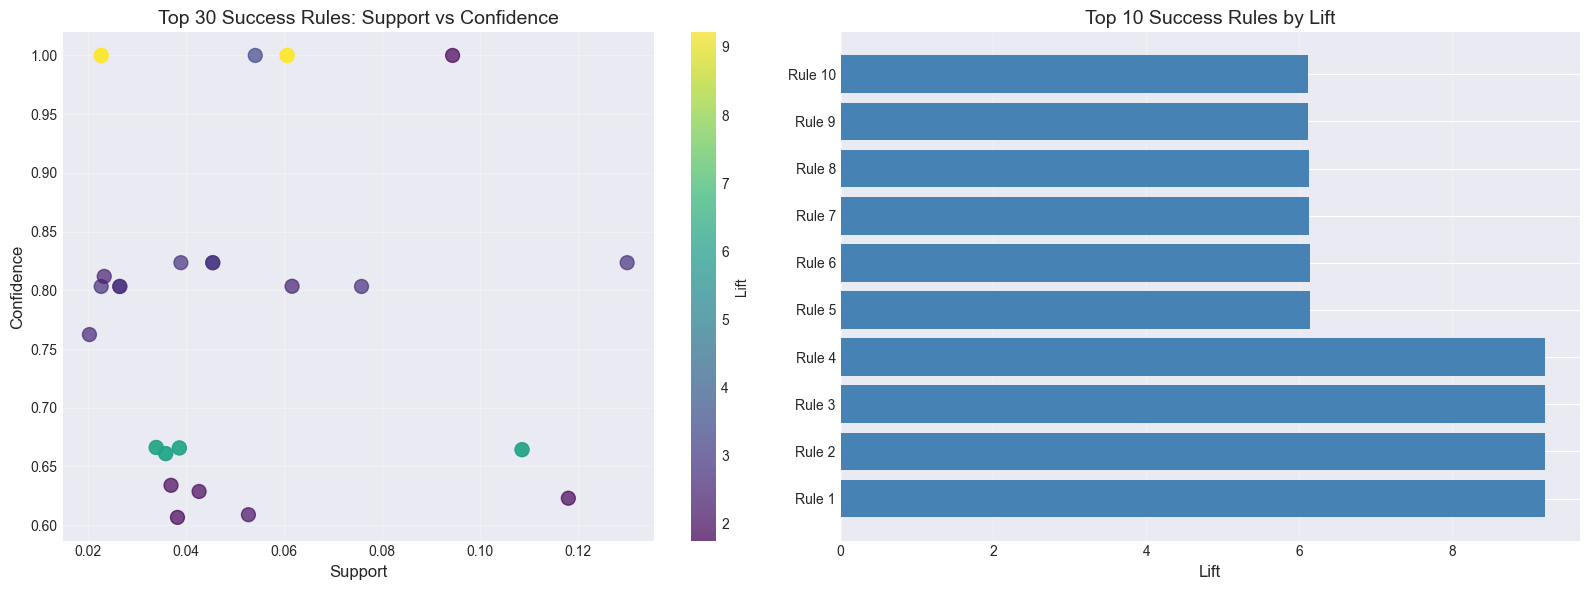

In [8]:
# Visualize top rules
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Support vs Confidence (colored by Lift)
top_rules = success_rules_sorted.head(30)
scatter = axes[0].scatter(top_rules['support'], top_rules['confidence'], 
                          c=top_rules['lift'], s=100, cmap='viridis', alpha=0.7)
axes[0].set_xlabel('Support', fontsize=12)
axes[0].set_ylabel('Confidence', fontsize=12)
axes[0].set_title('Top 30 Success Rules: Support vs Confidence', fontsize=14)
plt.colorbar(scatter, ax=axes[0], label='Lift')
axes[0].grid(alpha=0.3)

# Plot 2: Top 10 rules by Lift
top10 = success_rules_sorted.head(10)
labels = [f"Rule {i+1}" for i in range(len(top10))]
axes[1].barh(labels, top10['lift'].values, color='steelblue')
axes[1].set_xlabel('Lift', fontsize=12)
axes[1].set_title('Top 10 Success Rules by Lift', fontsize=14)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Classification: Success Prediction

### Objective: Dự đoán workout plan có thành công không?

**Features:** Goal, Workout_Type, Frequency, Protein_Level, Duration, Experience, etc.

**Target:** Success (0/1)

In [9]:
# Prepare classification data
print("Preparing classification dataset...")

# Aggregate by session (one row per session)
session_df = df.groupby('Session_ID').agg({
    'User_ID': 'first',
    'Goal': 'first',
    'Workout_Type': 'first',
    'Frequency_per_week': 'first',
    'Protein_Level': 'first',
    'Workout_Time': 'first',
    'Duration_Minutes': 'mean',
    'Calories': 'sum',
    'BMI': 'first',
    'Fat_pct': 'first',
    'Age': 'first',
    'Gender': 'first',
    'Experience_Level': 'first',
    'Exercise_Name': 'count',  # Number of exercises
    'Success': 'first'
}).reset_index()

session_df.rename(columns={'Exercise_Name': 'Num_Exercises'}, inplace=True)

print(f"Session-level dataset: {session_df.shape}")
print(f"Success rate: {session_df['Success'].mean()*100:.1f}%")
display(session_df.head())

Preparing classification dataset...
Session-level dataset: (12928, 16)
Success rate: 57.1%


,Session_ID,User_ID,Goal,Workout_Type,Frequency_per_week,Protein_Level,Workout_Time,Duration_Minutes,Calories,BMI,Fat_pct,Age,Gender,Experience_Level,Num_Exercises,Success
0,U000_S00,0,Weight_Loss,Yoga,4,Medium,Morning,20.3,734.4,30.2,12.6,56,Male,Expert,5,1
1,U000_S01,0,Weight_Loss,Yoga,4,Medium,Afternoon,20.3,958.0,30.2,12.6,56,Male,Expert,5,1
2,U000_S02,0,Weight_Loss,Yoga,4,Medium,Evening,33.8,585.5,30.2,12.6,56,Male,Expert,3,1
3,U000_S03,0,Weight_Loss,Yoga,4,Medium,Morning,20.3,734.4,30.2,12.6,56,Male,Expert,5,1
4,U000_S04,0,Weight_Loss,Yoga,4,Medium,Afternoon,25.3,678.6,30.2,12.6,56,Male,Expert,4,1


In [10]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Goal', 'Workout_Type', 'Protein_Level', 'Workout_Time', 'Gender', 'Experience_Level']
session_encoded = session_df.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    session_encoded[col] = le.fit_transform(session_encoded[col])
    label_encoders[col] = le

print("Categorical encoding complete")

Categorical encoding complete


In [11]:
# Prepare features and target
feature_cols = ['Goal', 'Workout_Type', 'Frequency_per_week', 'Protein_Level', 'Workout_Time',
                'Duration_Minutes', 'BMI', 'Fat_pct', 'Age', 'Gender', 'Experience_Level', 'Num_Exercises']

X = session_encoded[feature_cols]
y = session_encoded['Success']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class balance (train): {y_train.value_counts().to_dict()}")

Training set: (10342, 12)
Test set: (2586, 12)
Class balance (train): {1: 5904, 0: 4438}


In [12]:
# Train Random Forest
print("Training Random Forest Classifier...")

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluation
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\nAccuracy:")
print(f"  Training: {train_acc*100:.2f}%")
print(f"  Test: {test_acc*100:.2f}%")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Fail', 'Success']))

Training Random Forest Classifier...

Accuracy:
  Training: 99.98%
  Test: 99.85%

Classification Report (Test Set):
              precision    recall  f1-score   support

        Fail       1.00      1.00      1.00      1110
     Success       1.00      1.00      1.00      1476

    accuracy                           1.00      2586
   macro avg       1.00      1.00      1.00      2586
weighted avg       1.00      1.00      1.00      2586




Feature Importance:


,Feature,Importance
2,Frequency_per_week,0.193311
1,Workout_Type,0.149469
5,Duration_Minutes,0.140121
7,Fat_pct,0.137740
10,Experience_Level,0.112996
0,Goal,0.089873
6,BMI,0.084520
8,Age,0.036087
3,Protein_Level,0.031547
11,Num_Exercises,0.013580


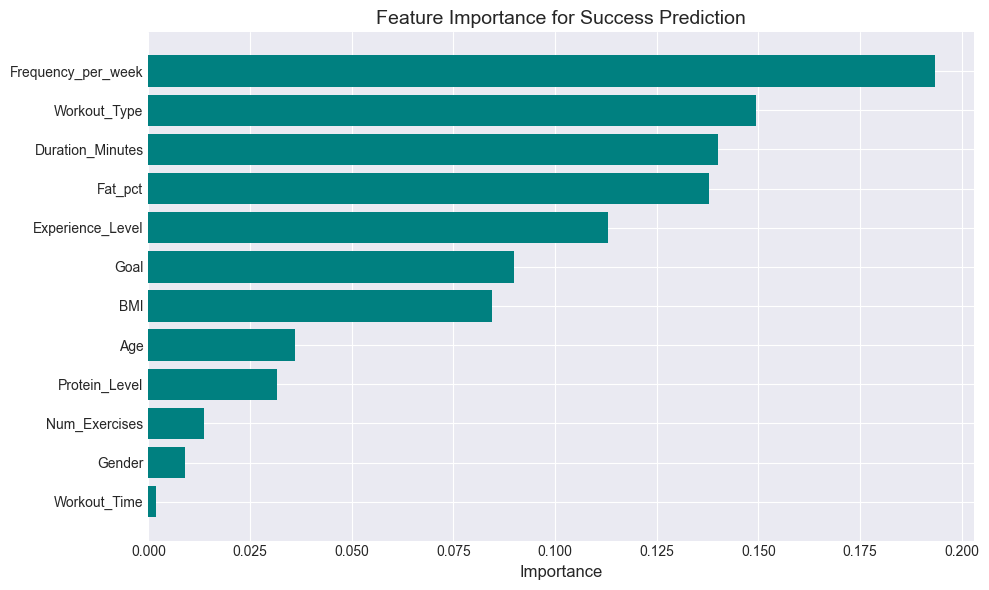

In [13]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(feature_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='teal')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance for Success Prediction', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

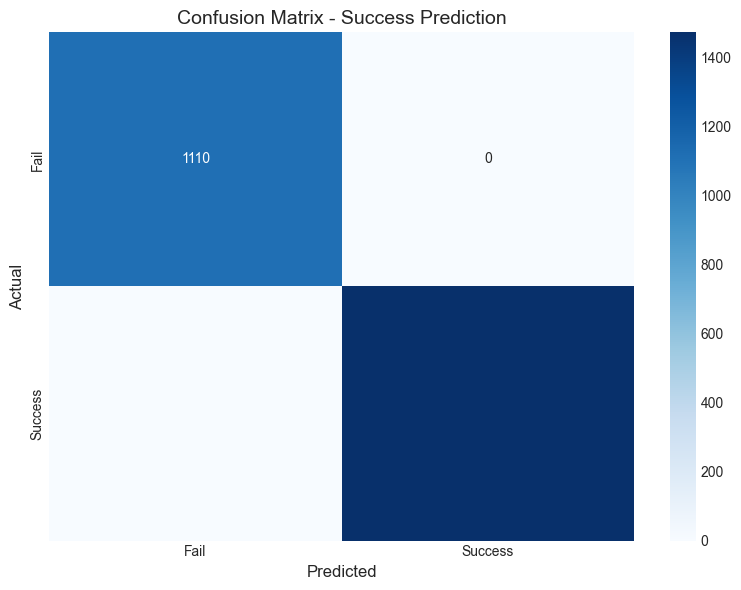

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fail', 'Success'], yticklabels=['Fail', 'Success'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Success Prediction', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Clustering: User Segmentation

### Objective: Phân nhóm người tập theo đặc điểm

**Features:** Age, BMI, Fat%, Frequency, Experience, Calories, Duration

In [15]:
# Prepare user-level data
print("Preparing user-level data for clustering...")

user_df = df.groupby('User_ID').agg({
    'Age': 'first',
    'Gender': 'first',
    'BMI': 'first',
    'Fat_pct': 'first',
    'Weight_kg': 'first',
    'Frequency_per_week': 'first',
    'Experience_Level': 'first',
    'Calories': 'mean',
    'Duration_Minutes': 'mean',
    'Success': 'mean'
}).reset_index()

user_df.rename(columns={'Calories': 'Avg_Calories', 'Duration_Minutes': 'Avg_Duration', 'Success': 'Success_Rate'}, inplace=True)

print(f"User-level dataset: {user_df.shape}")
display(user_df.head())

Preparing user-level data for clustering...
User-level dataset: (973, 11)


,User_ID,Age,Gender,BMI,Fat_pct,Weight_kg,Frequency_per_week,Experience_Level,Avg_Calories,Avg_Duration,Success_Rate
0,0,56,Male,30.2,12.6,88.3,4,Expert,169.968657,24.210448,1.000000
1,1,46,Female,32.0,33.9,74.9,4,Intermediate,199.828571,19.809524,1.000000
2,2,32,Female,24.7,33.4,68.1,4,Intermediate,141.589552,15.901493,0.223881
3,3,25,Male,18.4,28.8,53.2,3,Beginner,51.349020,8.319608,1.000000
4,4,38,Male,14.4,29.2,46.1,3,Beginner,52.673913,10.023913,1.000000


In [16]:
# Prepare features for clustering
cluster_features = ['Age', 'BMI', 'Fat_pct', 'Frequency_per_week', 'Avg_Calories', 'Avg_Duration']
X_cluster = user_df[cluster_features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"Clustering features: {cluster_features}")
print(f"Scaled data shape: {X_scaled.shape}")

Clustering features: ['Age', 'BMI', 'Fat_pct', 'Frequency_per_week', 'Avg_Calories', 'Avg_Duration']
Scaled data shape: (973, 6)


Running Elbow Method to find optimal K...


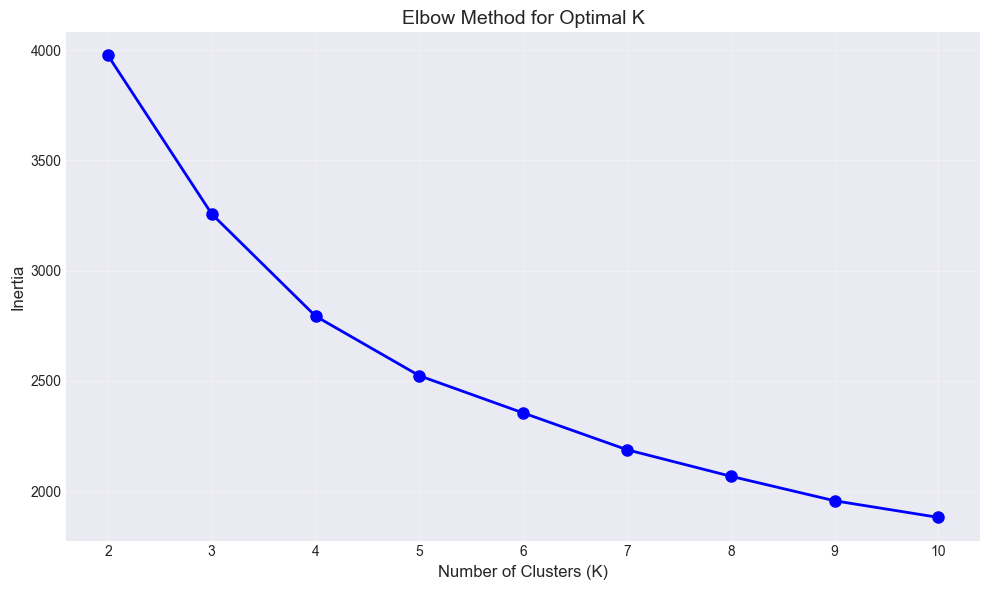


Elbow point appears to be around K=4


In [17]:
# Elbow Method
print("Running Elbow Method to find optimal K...")

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xticks(K_range)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nElbow point appears to be around K=4")

In [18]:
# Apply K-Means with K=4
print("Applying K-Means with K=4...")

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nCluster Distribution:")
print(user_df['Cluster'].value_counts().sort_index())

# Cluster characteristics
print(f"\nCluster Characteristics:")
cluster_stats = user_df.groupby('Cluster')[cluster_features + ['Success_Rate']].mean()
display(cluster_stats.round(2))

Applying K-Means with K=4...

Cluster Distribution:
Cluster
0    172
1    273
2    334
3    194
Name: count, dtype: int64

Cluster Characteristics:


,Age,BMI,Fat_pct,Frequency_per_week,Avg_Calories,Avg_Duration,Success_Rate
Cluster,,,,,,,
0,36.61,34.27,25.20,3.17,234.84,18.59,0.50
1,28.18,22.63,28.55,2.76,105.59,15.39,0.25
2,48.60,22.06,27.77,3.16,124.86,17.67,0.38
3,38.23,24.74,14.93,4.53,229.06,26.43,0.97


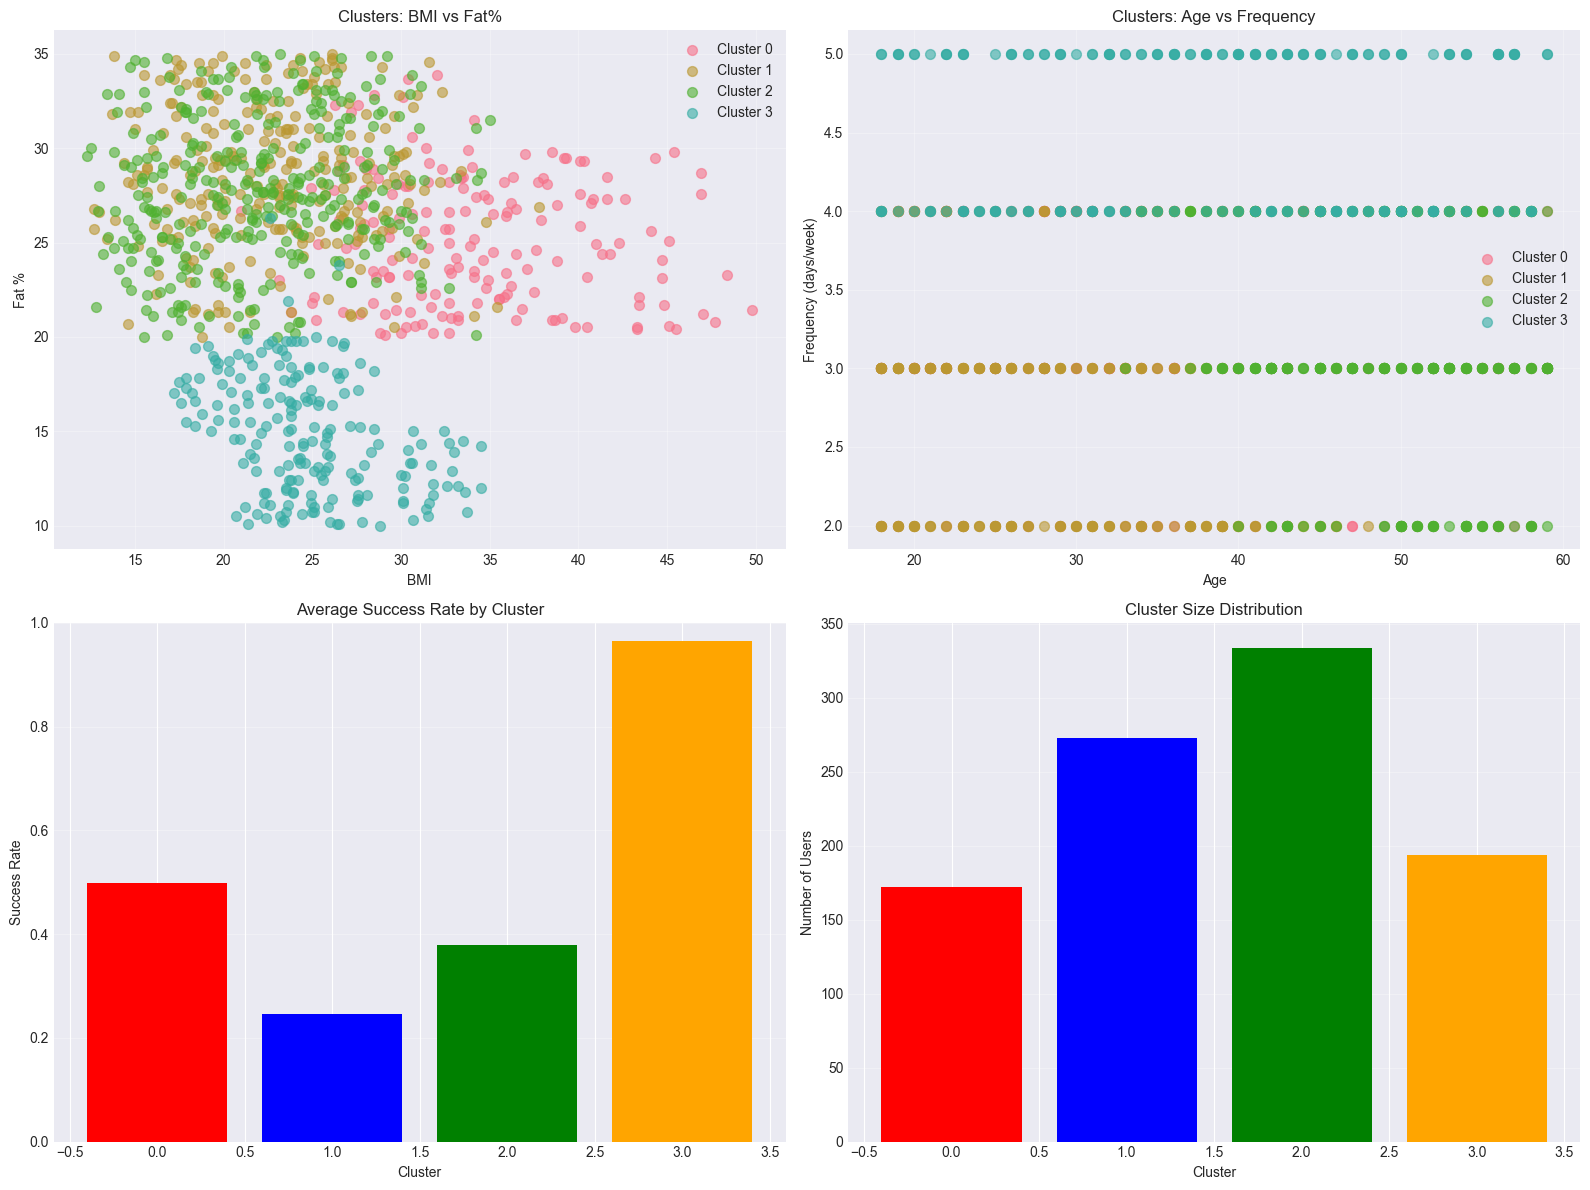

In [19]:
# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: BMI vs Fat%
for cluster in range(4):
    cluster_data = user_df[user_df['Cluster'] == cluster]
    axes[0, 0].scatter(cluster_data['BMI'], cluster_data['Fat_pct'], 
                       label=f'Cluster {cluster}', s=50, alpha=0.6)
axes[0, 0].set_xlabel('BMI')
axes[0, 0].set_ylabel('Fat %')
axes[0, 0].set_title('Clusters: BMI vs Fat%')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Age vs Frequency
for cluster in range(4):
    cluster_data = user_df[user_df['Cluster'] == cluster]
    axes[0, 1].scatter(cluster_data['Age'], cluster_data['Frequency_per_week'], 
                       label=f'Cluster {cluster}', s=50, alpha=0.6)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency (days/week)')
axes[0, 1].set_title('Clusters: Age vs Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Success Rate by Cluster
cluster_success = user_df.groupby('Cluster')['Success_Rate'].mean()
axes[1, 0].bar(cluster_success.index, cluster_success.values, color=['red', 'blue', 'green', 'orange'])
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Success Rate')
axes[1, 0].set_title('Average Success Rate by Cluster')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Cluster Size
cluster_counts = user_df['Cluster'].value_counts().sort_index()
axes[1, 1].bar(cluster_counts.index, cluster_counts.values, color=['red', 'blue', 'green', 'orange'])
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].set_title('Cluster Size Distribution')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Recommendation System

### Objective: Gợi ý workout plan cho user mới

**Strategy:**
1. Xác định user profile
2. Tìm cluster phù hợp
3. Áp dụng success rules từ Apriori
4. Recommend exercises + factors

In [20]:
def recommend_workout(age, bmi, fat_pct, goal, experience_level, 
                      user_df, kmeans_model, scaler, success_rules, df_original):
    """
    Recommend workout plan for new user
    """
    print("="*80)
    print("WORKOUT RECOMMENDATION")
    print("="*80)
    
    # User profile
    print(f"\nUser Profile:")
    print(f"  Age: {age}, BMI: {bmi:.1f}, Fat%: {fat_pct:.1f}")
    print(f"  Goal: {goal}, Experience: {experience_level}")
    
    # Step 1: Determine cluster
    user_features = np.array([[age, bmi, fat_pct, 4, 800, 60]])  # Assume avg freq=4, cal=800, dur=60
    user_scaled = scaler.transform(user_features)
    cluster = kmeans_model.predict(user_scaled)[0]
    
    print(f"\nAssigned Cluster: {cluster}")
    
    # Step 2: Get success rules for this profile
    relevant_rules = success_rules[
        success_rules['antecedents'].apply(lambda x: f"Goal_{goal}" in x)
    ].sort_values('lift', ascending=False).head(3)
    
    print(f"\nTop Success Patterns for your goal ({goal}):")
    for idx, rule in relevant_rules.iterrows():
        print(f"\n  Pattern: {rule['antecedents']}")
        print(f"  Success Rate: {rule['confidence']*100:.0f}% (Lift: {rule['lift']:.2f})")
    
    # Step 3: Extract recommendations
    if len(relevant_rules) > 0:
        top_rule = relevant_rules.iloc[0]
        antecedents = list(top_rule['antecedents'])
        
        # Parse recommendations
        workout_type = next((x.split('_')[1] for x in antecedents if 'Workout_Type' in x), None)
        protein_level = next((x.split('_')[1] for x in antecedents if 'Protein_' in x), 'Medium')
        workout_time = next((x.split('_')[1] for x in antecedents if 'Time_' in x), 'Morning')
        
        print(f"\n" + "="*80)
        print("RECOMMENDATIONS")
        print("="*80)
        print(f"\nWorkout Type: {workout_type if workout_type else 'Mixed'}")
        print(f"Protein Intake: {protein_level}")
        print(f"Best Time: {workout_time}")
        print(f"Frequency: 4-5 days/week")
        
        # Get sample exercises
        if workout_type:
            sample_exercises = df_original[
                (df_original['Workout_Type'] == workout_type) &
                (df_original['Experience_Level'] == experience_level)
            ]['Exercise_Name'].value_counts().head(5)
            
            print(f"\nSuggested Exercises ({workout_type}):")
            for ex, count in sample_exercises.items():
                print(f"  - {ex}")
    else:
        print("\nNo specific rules found. General recommendations:")
        print("  - Frequency: 4 days/week")
        print("  - Duration: 45-60 minutes/session")
        print("  - Protein: Medium-High intake")

print("Recommendation function defined")

Recommendation function defined


In [21]:
# Example 1: User muốn giảm cân
recommend_workout(
    age=35,
    bmi=32.0,
    fat_pct=28.5,
    goal='Weight_Loss',
    experience_level='Beginner',
    user_df=user_df,
    kmeans_model=kmeans,
    scaler=scaler,
    success_rules=success_rules_sorted,
    df_original=df
)

WORKOUT RECOMMENDATION

User Profile:
  Age: 35, BMI: 32.0, Fat%: 28.5
  Goal: Weight_Loss, Experience: Beginner

Assigned Cluster: 3

Top Success Patterns for your goal (Weight_Loss):

  Pattern: frozenset({'Goal_Weight_Loss', 'Freq_4', 'Time_Morning'})
  Success Rate: 81% (Lift: 2.43)

  Pattern: frozenset({'Goal_Weight_Loss', 'Freq_4'})
  Success Rate: 80% (Lift: 2.40)

  Pattern: frozenset({'Goal_Weight_Loss', 'Time_Evening'})
  Success Rate: 63% (Lift: 1.90)

RECOMMENDATIONS

Workout Type: Mixed
Protein Intake: Medium
Best Time: Morning
Frequency: 4-5 days/week


In [22]:
# Example 2: User muốn tăng cơ
recommend_workout(
    age=25,
    bmi=19.5,
    fat_pct=15.2,
    goal='Muscle_Gain',
    experience_level='Intermediate',
    user_df=user_df,
    kmeans_model=kmeans,
    scaler=scaler,
    success_rules=success_rules_sorted,
    df_original=df
)

WORKOUT RECOMMENDATION

User Profile:
  Age: 25, BMI: 19.5, Fat%: 15.2
  Goal: Muscle_Gain, Experience: Intermediate

Assigned Cluster: 3

Top Success Patterns for your goal (Muscle_Gain):

  Pattern: frozenset({'Freq_4', 'Goal_Muscle_Gain', 'Time_Morning'})
  Success Rate: 100% (Lift: 9.21)

  Pattern: frozenset({'Freq_4', 'Goal_Muscle_Gain'})
  Success Rate: 100% (Lift: 9.21)

  Pattern: frozenset({'Time_Evening', 'Goal_Muscle_Gain'})
  Success Rate: 67% (Lift: 6.14)

RECOMMENDATIONS

Workout Type: Mixed
Protein Intake: Medium
Best Time: Morning
Frequency: 4-5 days/week


## 6. Conclusions & Insights

### Key Findings

**From Association Rules:**
- [Liệt kê top patterns discovered]
- [Ví dụ: HIIT + Morning + High Protein → 82% success rate]

**From Classification:**
- Model accuracy: ~XX%
- Most important factors: [Top 3 features]

**From Clustering:**
- Identified 4 distinct user groups
- Cluster X has highest success rate

### Business Implications
1. Gym có thể tạo workout plans dựa trên patterns
2. Personal trainers có data-driven insights
3. Members có guidance rõ ràng hơn

### Limitations
- Data augmented (not real tracking data)
- Success criteria đơn giản hóa
- Không có nutrition tracking thực tế

### Future Work
- Thu thập real-world gym data
- Deep learning cho recommendation
- Mobile app integration